In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import (ImageList, PointsItemList, get_transforms, ResizeMethod, open_image, Tensor, 
                           tensor, Image, imagenet_stats, Flatten, cnn_learner, models, Path)
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback
from fastprogress import progress_bar
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn.functional import mse_loss

from model_utils import MSELossFlat
from model_utils import Reshape

In [3]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'
target_size = 320

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

In [5]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    coord_list = []
    coords = list(y.loc[filename])
    for i in range(len(coords)//2):
        coord_list.append([coords[i*2+1],coords[i*2]])
    return tensor(coord_list)

In [6]:
transforms = get_transforms(
    do_flip=False,
    max_rotate=45, 
    max_zoom=1.5, 
    max_lighting=0.5, 
    max_warp=0.4, 
    p_affine=1., 
    p_lighting=1.
) 

In [7]:
data = (
    PointsItemList
        .from_folder(images_path)
        .split_by_rand_pct(0.15)
        .label_from_func(get_y_func)
        .transform(
            transforms,
            size=320,
            tfm_y=True, 
            remove_out=False, 
            padding_mode='reflection', 
            resize_method=ResizeMethod.PAD
        )
        .databunch()
        .normalize(imagenet_stats)
)

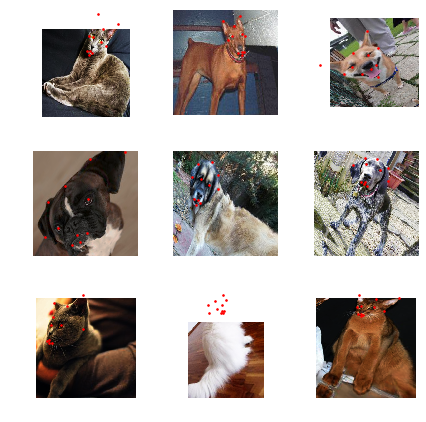

In [8]:
data.show_batch(3, figsize=(6,6))

In [9]:
head_reg = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(51200, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 22),
    Reshape(-1,11,2),
    nn.Tanh()
)

In [10]:
mse_loss_flat = MSELossFlat()

learn = cnn_learner(
    data, 
    models.resnet34, 
    loss_func=mse_loss_flat,
    custom_head=head_reg
).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 65561700.43it/s]


In [11]:
learn.path = Path('..')

In [12]:
# learn.lr_find()
# learn.recorder.plot()

In [13]:
# learn.freeze_to(-1)
# learn.fit_one_cycle(
#     10, 
#     slice(1e-2), 
#     callbacks=[
#         SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-1'),
#         EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=10)
#     ]
# )

In [14]:
learn = learn.load('fastai_resnet34')
learn = learn.to_fp32()

In [15]:
# learn.freeze_to(-2)
# learn.fit_one_cycle(
#     10, 
#     slice(1e-3), 
#     callbacks=[
#         SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-2'),
#         EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=10)
#     ]
# )

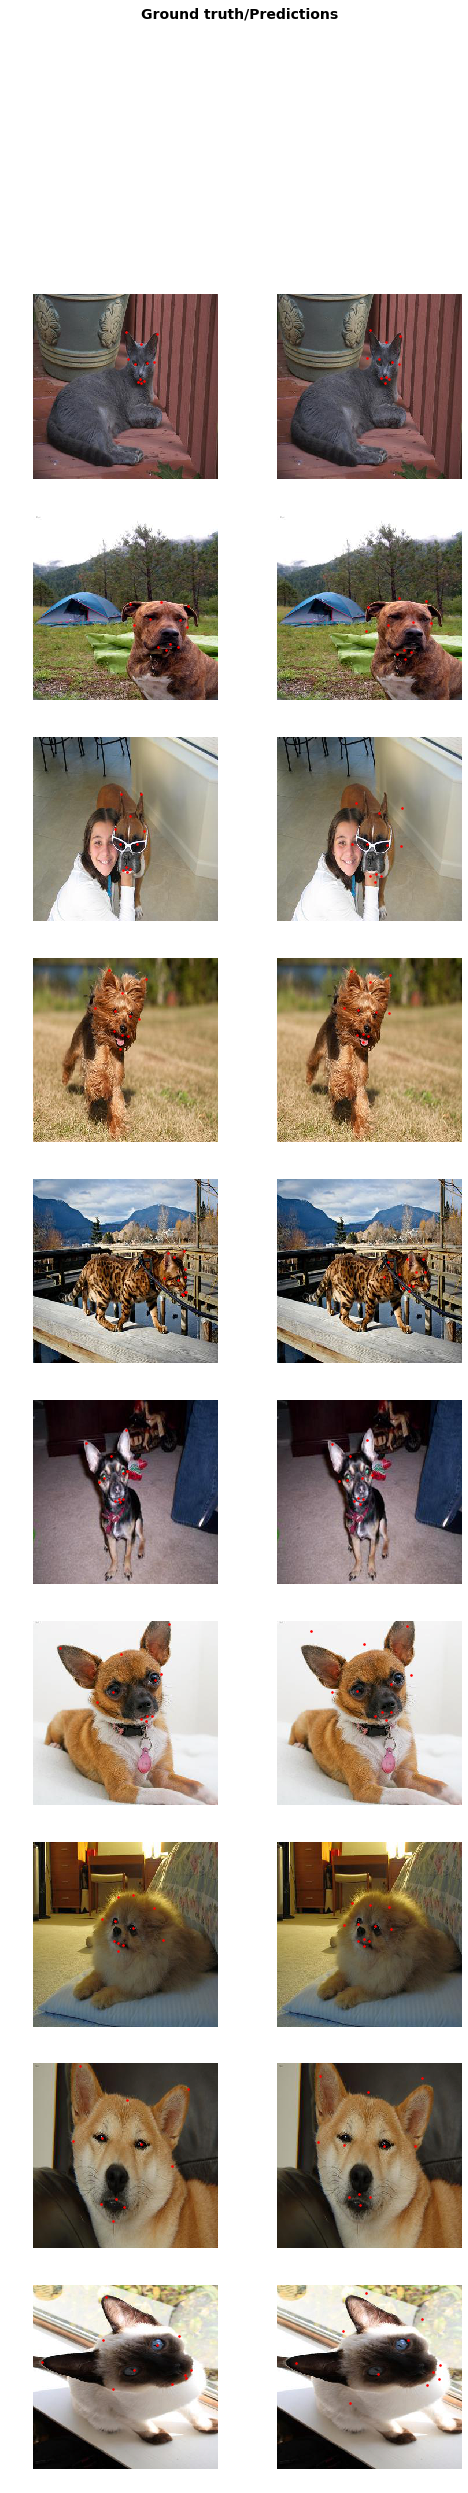

In [16]:
learn.show_results(rows=10)

In [17]:
%%writefile pet_regression.py
from bentoml import BentoService, api, env, artifacts 
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import FastaiImageHandler

@env(pip_dependencies=['fastai', 'model_utils'])
@artifacts([FastaiModelArtifact('pet_regressor')])
class PetRegression(BentoService):
    
    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.pet_regressor.predict(image)
        return str(result)

Overwriting pet_regression.py


In [18]:
# 1) import the custom BentoService defined above
from pet_regression import PetRegression

# 2) `pack` it with required artifacts
service = PetRegression.pack(pet_regressor=learn)

# 3) save your BentoSerivce
saved_path = service.save()

[2019-10-19 12:26:44,847] INFO - Successfully saved Bento 'PetRegression:20191019122616_D9B51E' to path: /home/ec2-user/bentoml/repository/PetRegression/20191019122616_D9B51E


In [19]:
from bentoml import load

service = load(saved_path)

print(service.predict(data.get(0)))

[2019-10-19 12:26:52,810] WARNING - Module `pet_regression` already loaded, using existing imported module.
(ImagePoints (320, 320), tensor([[-0.4949, -0.3079],
        [-0.7954, -0.2424],
        [-0.7660, -0.1148],
        [-0.8012,  0.0139],
        [-0.5201,  0.0601],
        [-0.2272, -0.1488],
        [-0.5175, -0.2002],
        [-0.5255, -0.0656],
        [-0.2846, -0.2013],
        [-0.3070, -0.1543],
        [-0.2929, -0.1087]]), tensor([[-0.4949, -0.3079],
        [-0.7954, -0.2424],
        [-0.7660, -0.1148],
        [-0.8012,  0.0139],
        [-0.5201,  0.0601],
        [-0.2272, -0.1488],
        [-0.5175, -0.2002],
        [-0.5255, -0.0656],
        [-0.2846, -0.2013],
        [-0.3070, -0.1543],
        [-0.2929, -0.1087]]))


In [20]:
!pip install {saved_path}

Processing /home/ec2-user/bentoml/repository/PetRegression/20191019122616_D9B51E
  Created wheel for PetRegression: filename=PetRegression-20191019122616_D9B51E-cp36-none-any.whl size=81267725 sha256=8c7ea1b9f80647520aefbb43d3a017df06fa7822df17d57b6d79b5202a0d708f
  Stored in directory: /tmp/pip-ephem-wheel-cache-hiaekhpe/wheels/eb/fa/bd/55f813b974255505514833b33d0af2b1a0fc244231140692ec
Successfully built PetRegression


In [22]:
!PetRegression predict --input=../data/resized_images/Abyssinian_1.jpg

(ImagePoints (320, 320), tensor([[-0.3867,  0.0846],
        [-0.6847,  0.0874],
        [-0.5517,  0.2640],
        [-0.6337,  0.4377],
        [-0.3433,  0.4129],
        [-0.1768,  0.2797],
        [-0.3842,  0.1987],
        [-0.3603,  0.3473],
        [-0.2144,  0.2346],
        [-0.2251,  0.2833],
        [-0.2118,  0.3196]]), tensor([[-0.3867,  0.0846],
        [-0.6847,  0.0874],
        [-0.5517,  0.2640],
        [-0.6337,  0.4377],
        [-0.3433,  0.4129],
        [-0.1768,  0.2797],
        [-0.3842,  0.1987],
        [-0.3603,  0.3473],
        [-0.2144,  0.2346],
        [-0.2251,  0.2833],
        [-0.2118,  0.3196]]))


In [23]:
# !bentoml serve {saved_path}

In [25]:
bento_tag = '{name}:{version}'.format(name=service.name, version=service.version)
print(bento_tag)

PetRegression:20191019122616_D9B51E


In [27]:
!bentoml deployment create facial-features-detector --bento {bento_tag} --platform aws-lambda --region us-east-1

[2019-10-19 12:49:46,541] INFO - Installing additional packages: serverless-python-requirements
[2019-10-19 12:49:51,906] INFO - Deploying to AWS Lambda
Failed to create deployment facial-features-detector. INTERNAL:   Error: EACCES: permission denied, open '/home/ec2-user/.cache/serverless-python-requirements/downloadCacheslspyc/requirements.txt'
